In [18]:
from sklearn.neighbors import KernelDensity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import scipy as sc
from scipy.integrate import quad
from scipy.optimize import minimize
import warnings
import inspect

### Combining and rearranging data

In [4]:
## Combines all years NTL data and evaluates NTL per capita
def get_all_ntl_countries_data(years, pop_df):
    combined_ntl_df = pd.DataFrame()
    
    for year in years:
        ntl_df = pd.read_csv("./data/earth_observation_group/annual/{}/countries_ntl_sum.csv".format(year))
        ntl_df["annual_ntl_sum"] = ntl_df["annual_ntl_sum"]*365.0
        
        ntl_df = ntl_df.set_index("Region Code").join(pop_df.set_index("Country Code")[str(year)])
        ntl_df["annual_ntl_sum"] = ntl_df["annual_ntl_sum"]/ntl_df[str(year)]
        ntl_df = ntl_df[ntl_df["annual_ntl_sum"] > 0.0]
        ntl_df.drop(columns=str(year), inplace=True)
        ntl_df.rename(columns={"annual_ntl_sum": "annual_ntl_sum_per_capita_{}".format(year)}, inplace=True)
        
        ntl_df.reset_index(inplace=True)

        if combined_ntl_df.empty:
            combined_ntl_df = copy.copy(ntl_df)   
        else:
            combined_ntl_df = combined_ntl_df.set_index("Region Code").join(ntl_df.set_index("Region Code"))
    return combined_ntl_df.reset_index()

In [6]:
years = [year for year in range(2013, 2015)]
pop_df = pd.read_csv("./data/population/API_SP.POP.TOTL_DS2_en_csv_v2_5358404.csv")
combined_ntl_df = get_all_ntl_countries_data(years, pop_df)

In [5]:
combined_ntl_df.head()

,Region Code,annual_ntl_sum_per_capita_2013,annual_ntl_sum_per_capita_2014
0,SMR,25.910011,40.292222
1,SVK,11.706804,20.328627
2,HTI,0.688323,0.541338
3,DOM,6.176171,6.083773
4,TJK,10.157903,10.974082


In [6]:
spi_and_centroid_df = pd.read_csv("./data/SPI_index_mean_and_centroid_latitude.csv")
columns_to_choose = ["iso3c", "spi_category", "centroid_category"]
spi_and_centroid_df = spi_and_centroid_df[columns_to_choose]
spi_and_centroid_df.rename(columns={"iso3c": "Region Code"}, inplace=True)

In [7]:
gdp_df = pd.read_csv("./data/gdp/gdp_per_capita.csv")

In [8]:
columns_to_choose = ["Country Code"]
columns_to_choose.extend([str(year) for year in years])

gdp_df = gdp_df[columns_to_choose]

new_column_names = {str(year): "gdp_"+str(year) for year in years}
new_column_names["Country Code"] = "Region Code"
gdp_df.rename(columns=new_column_names, inplace=True)

In [9]:
all_params_df = pd.merge(gdp_df, combined_ntl_df, on="Region Code")

In [10]:
all_params_df = all_params_df.merge(spi_and_centroid_df, on="Region Code")

In [11]:
all_params_df = all_params_df.dropna().reset_index(drop=True)

In [12]:
all_params_df.to_csv("./data/imf_data_combined.csv", index=False)

In [13]:
all_params_df.head(3)

,Region Code,gdp_2013,gdp_2014,annual_ntl_sum_per_capita_2013,annual_ntl_sum_per_capita_2014,spi_category,centroid_category
0,AFG,651.987862,628.146804,7.584208,7.642673,3,2
1,AGO,5101.983876,5059.080441,10.256121,4.550744,3,1
2,AUT,50731.127254,51786.377175,12.279653,19.879445,1,2


In [9]:
all_params_df = pd.read_csv("./data/imf_data_combined.csv")
all_params_df.head(3)

,Region Code,gdp_2013,gdp_2014,gdp_2015,gdp_2016,gdp_2017,gdp_2018,gdp_2019,gdp_2020,gdp_2021,...,annual_ntl_sum_per_capita_2014,annual_ntl_sum_per_capita_2015,annual_ntl_sum_per_capita_2016,annual_ntl_sum_per_capita_2017,annual_ntl_sum_per_capita_2018,annual_ntl_sum_per_capita_2019,annual_ntl_sum_per_capita_2020,annual_ntl_sum_per_capita_2021,spi_category,centroid_category
0,AFG,651.987862,628.146804,592.476537,520.252064,530.149831,502.056771,500.522664,516.866552,368.754614,...,7.642676,6.671029,4.199140,12.494798,10.355789,9.807101,11.385088,12.541621,3,2
1,AGO,5101.983876,5059.080441,3100.830685,1709.515534,2283.214233,2487.500996,2142.238757,1603.993477,1953.533757,...,4.550739,6.196695,4.646604,16.142245,16.123125,12.963231,15.475838,18.642648,3,1
2,ALB,4413.062005,4578.633208,3952.802538,4124.055390,4531.019374,5287.663694,5396.215864,5332.160475,6492.872012,...,15.203854,13.331281,11.614628,16.726026,16.894529,18.451795,20.337911,23.364682,2,2


In [16]:
tmp = {idx: row for idx, row in all_params_df["spi_category"].value_counts().iteritems()}

### Sieve Maximum Likelihood Estimation

In [15]:
# class IterationLimit(Warning):
#     pass

# class Trigger(Exception):
#     pass

class Optimizer:
    def __init__(self, all_params_df, years, num_hermite_polynomials, init_params, max_iters, bounds=None, 
                method="BFGS", method_options=None):
        self.all_params_df = all_params_df
        self.years = years
        self.num_hermite_polynomials = num_hermite_polynomials
        self.init_params = init_params
        self.bounds = bounds
        self.method = method
        self.method_options = method_options
        
        self.num_iters = 0
        self.max_iters = max_iters
        
        # Probability of occurence of spi and centroid categories
        self.categories_prob = {
            "spi": {idx: row for idx, row in self.all_params_df["spi_category"].value_counts().iteritems()},
            "centroid": {idx: row for idx, row in self.all_params_df["centroid_category"].value_counts().iteritems()}
        }
        
    def callback(self, x):
        self.num_iters += 1
        
        print("Current params: ", x)
        print("_"*10)
        if self.num_iters == self.max_iters:
            raise StopIteration
#             warnings.warn("Iterations limit reached, terminating optimization.", IterationLimit)
#             return True
        else:
            print("Iterations elapsed: ", self.num_iters)
#             return False
        
        
    def integrand(self, y_star, y, gdp_error_std, z, ntl_error_std, regression_params, 
                  num_hermite_polynomials):
        ## Square in the following term is because f(y*|s_i) = f(y*|l_i) since we are using the same
        ## weights in both the cases
        real_gdp_pdf = self.get_real_gdp_pdf(y_star, num_hermite_polynomials)**2
        gdp_error_pdf = self.get_gdp_error_pdf(y_star, y, gdp_error_std)
        ntl_error_pdf = self.get_ntl_error_pdf(y_star, z, ntl_error_std, regression_params)

        return real_gdp_pdf * gdp_error_pdf * ntl_error_pdf
        
    ## returns log-likelihood for a single observation i.e single year NTL and GDP for a country.
    def get_log_llh_country(self, gdp, ntl, gdp_error_std, ntl_error_std, regression_params, spi_prob, 
                            centroid_prob, num_hermite_polynomials):
        gdp_log = np.log(gdp)
        ntl_log = np.log(ntl)

        integral = quad(self.integrand, 1, 6, args=(gdp_log, gdp_error_std, ntl_log, ntl_error_std, 
                                                    regression_params, num_hermite_polynomials))[0]

        res = np.log(integral) + np.log(spi_prob * centroid_prob)
        return res

    
    def get_real_gdp_pdf(self, y_star, num_hermite_polynomials):
        res = 0.0
        weight = 1/np.sqrt(num_hermite_polynomials) 
        for degree in range(1, num_hermite_polynomials+1):
            res += self.get_hermite_polynomial(y_star, degree) * weight
        return res**2


    def get_gdp_error_pdf(self, y_star, y, gdp_error_std):
        return sc.stats.norm.pdf(y - y_star, 0.0, gdp_error_std)

    def get_ntl_error_pdf(self, y_star, z, ntl_error_std, regression_params):
        z_pred = regression_params[0] + regression_params[1] * y_star + regression_params[2] * (y_star**2)
        return sc.stats.norm.pdf(z - z_pred, 0.0, ntl_error_std)


    def get_hermite_polynomial(self, x, degree):
        hermite_polynomial = {
            1: lambda x: x,
            2: lambda x: x**2 - 1,
            3: lambda x: x**3 - 3*x,
            4: lambda x: x**4 - 6*(x**2) + 3,
            5: lambda x: x**5 - 10*(x**3) + 15*x,
            6: lambda x: x**6 - 15*(x**4) + 45*(x**2) - 15
        }
        return hermite_polynomial[degree](x)
    
    
    def mle_norm(self, parameters):
        self.num_iters += 1
        theta_0, theta_1, theta_2, gdp_error_std_cat_1, gdp_error_std_cat_2, gdp_error_std_cat_3, ntl_error_std_cat_1, ntl_error_std_cat_2 = parameters

        error_terms_dict = {
            "spi": {
                1: gdp_error_std_cat_1,
                2: gdp_error_std_cat_2,
                3: gdp_error_std_cat_3
            },
            "centroid": {
                1: ntl_error_std_cat_1,
                2: ntl_error_std_cat_2
            }
        }

        ## Sum of joint loglikelihood for all the observations
        total_llhd = 0.0

        for _, row in self.all_params_df.iterrows():
            spi_cat = row["spi_category"]
            centroid_cat = row["centroid_category"]

            for year in self.years:
                gdp = row["gdp_{}".format(year)]
                ntl = row["annual_ntl_sum_per_capita_{}".format(year)]
                total_llhd += self.get_log_llh_country(gdp, ntl, error_terms_dict["spi"][spi_cat], 
                                                       error_terms_dict["centroid"][centroid_cat], 
                                                       (theta_0, theta_1, theta_2), 
                                                       self.categories_prob["spi"][spi_cat], 
                                                       self.categories_prob["centroid"][centroid_cat],
                                                       self.num_hermite_polynomials)
        print("llhd: ", -1.0*total_llhd)
        print("params: ", parameters)
        
        return -1.0 * total_llhd
    
            
    def optimize(self):
        mle_model = minimize(self.mle_norm, 
                             self.init_params, 
                             method=self.method, 
                             callback=self.callback, 
                             options=self.method_options, 
                             bounds=self.bounds)
        return mle_model
        

In [16]:
# ## returns log-likelihood for a single observation i.e single year NTL and GDP for a country.
# def get_log_llh_country(gdp, ntl, gdp_error_std, ntl_error_std, regression_params, spi_prob, centroid_prob, 
#                        num_hermite_polynomials):
#     gdp_log = np.log(gdp)
#     ntl_log = np.log(ntl)
    
#     def integrand(y_star, y, gdp_error_std, z, ntl_error_std, regression_params, num_hermite_polynomials):
#         ## Square in the following term is because f(y*|s_i) = f(y*|l_i) since we are using the same
#         ## weights in both the cases
#         real_gdp_pdf = get_real_gdp_pdf(y_star, num_hermite_polynomials)**2
#         gdp_error_pdf = get_gdp_error_pdf(y_star, y, gdp_error_std)
#         ntl_error_pdf = get_ntl_error_pdf(y_star, z, ntl_error_std, regression_params)
        
#         return real_gdp_pdf * gdp_error_pdf * ntl_error_pdf
    
# #     integral = quad(integrand, 0.0, np.inf, args=(gdp_log, gdp_error_std, ntl_log, ntl_error_std, 
# #                                                   regression_params, num_hermite_polynomials))[0]
    
#     integral = quad(integrand, 1, 6, args=(gdp_log, gdp_error_std, ntl_log, ntl_error_std, 
#                                                   regression_params, num_hermite_polynomials))[0]
    
# #     print("integral: ", integral)
    
#     #     if integral == 0.0:
# #         return -10**4
    
#     res = np.log(integral) + np.log(spi_prob * centroid_prob)
#     return res

    
# def get_real_gdp_pdf(y_star, num_hermite_polynomials):
#     res = 0.0
#     weight = 1/np.sqrt(num_hermite_polynomials) 
#     for degree in range(1, num_hermite_polynomials+1):
#         res += get_hermite_polynomial(y_star, degree) * weight
#     return res**2
    
    
# def get_gdp_error_pdf(y_star, y, gdp_error_std):
#     return sc.stats.norm.pdf(y - y_star, 0.0, gdp_error_std)

# def get_ntl_error_pdf(y_star, z, ntl_error_std, regression_params):
#     z_pred = regression_params[0] + regression_params[1] * y_star + regression_params[2] * (y_star**2)
#     return sc.stats.norm.pdf(z - z_pred, 0.0, ntl_error_std)
    
    
# def get_hermite_polynomial(x, degree):
#     hermite_polynomial = {
#         1: lambda x: x,
#         2: lambda x: x**2 - 1,
#         3: lambda x: x**3 - 3*x,
#         4: lambda x: x**4 - 6*(x**2) + 3,
#         5: lambda x: x**5 - 10*(x**3) + 15*x,
#         6: lambda x: x**6 - 15*(x**4) + 45*(x**2) - 15
#     }
#     return hermite_polynomial[degree](x)
    

In [18]:
method = "BFGS"
years = [2013, 2014]
num_hermite_polynomials = 4
max_iters = 2
# init_params = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# init_params = [0.5, 1.0, -0.1, 1.0, 1.0, 1.0, 1.0, 1.0]
init_params = [ 0.13145964, -1.22748102, 0.26903948, 4.55958534, 2.47690282, 2.02219325, 1.09059137, 
               1.75088386]
bounds = ((None, None), (None, None), (None, None), (0.0, 10**2), (0.0, 10**2), (0.0, 10**2), 
         (0.0, 10**2), (0.0, 10**2))

# method_options = {"gtol": 1e-3}
method_options = {
    "maxfun": max_iters
}

optimizer = Optimizer(all_params_df, years, num_hermite_polynomials, init_params, max_iters, bounds=bounds, 
                method=method, method_options=method_options)

optimizer.optimize()

/home/ankur/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/tmp/ipykernel_20842/2880911468.py:131: OptimizeWarning: Unknown solver options: maxfun
  mle_model = minimize(self.mle_norm,


llhd:  -4731.620067290995
params:  [ 0.13145964 -1.22748102  0.26903948  4.55958534  2.47690282  2.02219325
  1.09059137  1.75088386]
llhd:  -4731.620067291246
params:  [ 0.13145965 -1.22748102  0.26903948  4.55958534  2.47690282  2.02219325
  1.09059137  1.75088386]
llhd:  -4731.620067291516
params:  [ 0.13145964 -1.22748101  0.26903948  4.55958534  2.47690282  2.02219325
  1.09059137  1.75088386]
llhd:  -4731.620067294915
params:  [ 0.13145964 -1.22748102  0.26903949  4.55958534  2.47690282  2.02219325
  1.09059137  1.75088386]
llhd:  -4731.6200672911
params:  [ 0.13145964 -1.22748102  0.26903948  4.55958535  2.47690282  2.02219325
  1.09059137  1.75088386]
llhd:  -4731.620067292167
params:  [ 0.13145964 -1.22748102  0.26903948  4.55958534  2.47690283  2.02219325
  1.09059137  1.75088386]


KeyboardInterrupt: 

#### The error parameters seem to be converging a lot faster than regression parameters. It might be because of less number of data points and it might improve when we have data for all the years.

In [111]:
mle_model.x

array([ 0.5,  1. , -0.1,  1. ,  1. ,  1. ,  1. ,  1. ])

In [181]:
def func(params):
    a, b = params
    return 10.0


count = 0
def tmp_callback(x):
    count += 1
    print("num iters: ", count)
    print(x)
    return False

init_params = [1.0, 1.0]
method = "COBYLA"

mle_model = minimize(func, init_params, method=method, callback=tmp_callback)

capi_return is NULL
Call-back cb_callback_in__cobyla__user__routines failed.


UnboundLocalError: local variable 'count' referenced before assignment

In [244]:
import scipy

In [245]:
scipy.__version__

'1.8.0'

In [243]:
task = "START"

task_str = task.tobytes()
# if task_str.startswith(b'FG'):

AttributeError: 'str' object has no attribute 'tobytes'

In [19]:
combined_df = pd.read_csv("./data/imf_data_combined.csv")

In [20]:
combined_df.head(3)

,Region Code,gdp_2013,gdp_2014,gdp_2015,gdp_2016,gdp_2017,gdp_2018,gdp_2019,gdp_2020,gdp_2021,...,annual_ntl_sum_per_capita_2014,annual_ntl_sum_per_capita_2015,annual_ntl_sum_per_capita_2016,annual_ntl_sum_per_capita_2017,annual_ntl_sum_per_capita_2018,annual_ntl_sum_per_capita_2019,annual_ntl_sum_per_capita_2020,annual_ntl_sum_per_capita_2021,spi_category,centroid_category
0,AFG,651.987862,628.146804,592.476537,520.252064,530.149831,502.056771,500.522664,516.866552,368.754614,...,7.642676,6.671029,4.199140,12.494798,10.355789,9.807101,11.385088,12.541621,3,2
1,AGO,5101.983876,5059.080441,3100.830685,1709.515534,2283.214233,2487.500996,2142.238757,1603.993477,1953.533757,...,4.550739,6.196695,4.646604,16.142245,16.123125,12.963231,15.475838,18.642648,3,1
2,ALB,4413.062005,4578.633208,3952.802538,4124.055390,4531.019374,5287.663694,5396.215864,5332.160475,6492.872012,...,15.203854,13.331281,11.614628,16.726026,16.894529,18.451795,20.337911,23.364682,2,2


In [21]:
import matplotlib.pyplot as plt

In [28]:
x, y = [], []
for year in range(2013, 2022):
    [x.append(val) for val in np.log(combined_df["gdp_{}".format(year)])]
    [y.append(val) for val in np.log(combined_df["annual_ntl_sum_per_capita_{}".format(year)])]

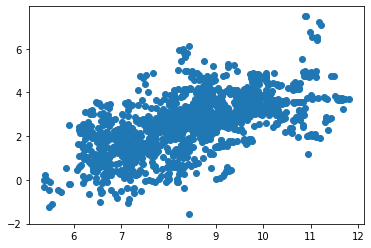

In [30]:
plt.scatter(x, y)